# Segment Anything in Medical Images ([colab](https://colab.research.google.com/drive/1N4wv9jljtEZ_w-f92iOLXCdkD-KJlsJH?usp=sharing))
Segmentation is a fundamental task in medical imaging analysis. Deep learning-based models have shown great promise in medical image segmentation due to their ability to learn intricate image features and deliver accurate segmentation results across a diverse range of tasks. Recently, the Segmentation Anything Model (SAM) has shown remarkable versatility and performance in natural image segmentation. However, their application to medical image segmentation has been challenging due to the substantial domain gap. In this tutorial, we will introduce how to adapt the SAM's success to medical image segmentation.

## Overview

0. Installation
1. Methodology introduction
2. Load pre-trained model
3. Load data and run inference in an interactive way
4. Others
   - a. Fine-tuning with customized datasets
   - b. Medical image segmentation with text-based prompts
   - c. Medical image segmentation with point-based prompts

## Installation is super easy. 
On the local device:
- Create a fresh environment `conda create -n medsam python=3.10 -y` and activate it `conda activate medsam`
- Install [pytorch 2.0](https://pytorch.org/get-started/locally/)
- Run the following command.

If you are using Colab, you can directly run the following command. 

In [4]:
#!pip install git+https://github.com/bowang-lab/MedSAM.git

## 1. Methodology introduction

SAM is a promptable segmentation model and it supports three types of prompts: bounding box, point, and text. (Note: The text-prompt function in SAM is not publicly available.) While the concept of fully automatic medical image segmentation foundation models is enticing, it is fraught with challenges that make it impractical. One of the primary challenges is the variability inherent in segmentation tasks. For example, given a liver cancer CT image, the segmentation task can vary depending on the specific clinical scenario. One clinician might be interested in segmenting the liver tumor, while another might need to segment the entire liver and surrounding organs. Additionally, the variability in imaging modalities presents another challenge. Modalities such as CT and MR generate 3D images, whereas others like X-Ray and ultrasound yield 2D images. These variabilities in task definition and imaging modalities complicate the design of a fully automatic model capable of accurately anticipating and addressing the diverse requirements of different users.

Considering these challenges, we argue that a more practical approach is to develop a promptable 2D model for general medical image segmentation. The model can be easily adapted to specific tasks based on user-provided prompts, offering enhanced flexibility and adaptability. It is also able to handle both 2D and 3D images by processing 3D images as a series of 2D slices. Compared to point-based and text-based prompts, the bounding box-based prompt has three main advantages: 1) it has less ambiguity and can clearly specify the ROI with minor user intervention (clicking on the top left and bottom right points); 2) it doesn't require multiple trial and error; 3) it can be seamlessly integrated into tumor measurements (e.g., Response Evaluation Criteria In Solid Tumors [RECIST](https://radiologyassistant.nl/more/recist-1-1/recist-1-1)) by simulating bounding box from the linear annotation (e.g., long axis and short axis).  


In order to use the pre-trained weights, we follow SAM's network architecture in SAM, including an image encoder, a prompt encoder, and a mask decoder. The image encoder maps the input image into a high-dimensional image embedding space. The prompt encoder transforms the user-drawn bounding boxes into feature representations via positional encoding. Finally, the mask decoder fuses the image embedding and prompt features using cross-attention. It should be noted that the image embedding only needs to be computed once during inference. Then, one can draw different bounding boxes to segment different targets in real-time. 

![network](assets/architecture.png)

## 2. Load pre-trained model

Please download the checkpoint [here](https://drive.google.com/drive/folders/1ETWmi4AiniJeWOt6HAsYgTjYv_fkgzoN?usp=drive_link). This pre-trained model can be directed loaded with SAM's checkpoint loader. 

In [7]:
import os
os.chdir("/scratch/mtc5693/MedSAM")

In [71]:

!conda run -n medsam2 python train_one_gpu.py \
-i data/npy/CT_YourData \
-num_epochs 50 \
-batch_size 4 \
-num_workers 4 \
-use_amp


Number of total parameters: 93735472
Number of trainable parameters: 93729252
Number of image encoder and mask decoder parameters: 93729252
number of images: 99
🚀 Starting training...
Epoch [1/50] - Batch [1/25] - Loss: 0.5387 - Step Time: 1.35s
Epoch [1/50] - Batch [2/25] - Loss: 0.4820 - Step Time: 0.34s
Epoch [1/50] - Batch [3/25] - Loss: 0.3096 - Step Time: 0.44s
Epoch [1/50] - Batch [4/25] - Loss: 0.3020 - Step Time: 0.36s
Epoch [1/50] - Batch [5/25] - Loss: 0.2640 - Step Time: 0.36s
Epoch [1/50] - Batch [6/25] - Loss: 0.4004 - Step Time: 0.34s
Epoch [1/50] - Batch [7/25] - Loss: 0.1438 - Step Time: 0.35s
Epoch [1/50] - Batch [8/25] - Loss: 0.2328 - Step Time: 0.35s
Epoch [1/50] - Batch [9/25] - Loss: 0.3661 - Step Time: 0.35s
Epoch [1/50] - Batch [10/25] - Loss: 0.1767 - Step Time: 0.35s
Epoch [1/50] - Batch [11/25] - Loss: 0.1313 - Step Time: 0.35s
Epoch [1/50] - Batch [12/25] - Loss: 0.1321 - Step Time: 0.36s
Epoch [1/50] - Batch [13/25] - Loss: 0.1386 - Step Time: 0.35s
Epoch 

In [72]:
best_path="/scratch/mtc5693/MedSAM/work_dir/MedSAM-ViT-B-20250405-2141/medsam_model_best.pth"
!conda run -n medsam2 python utils/ckpt_convert.py \
--sam_ckpt_path /scratch/mtc5693/MedSAM/work_dir/SAM/sam_vit_b_01ec64.pth \
--medsam_ckpt_path $best_path \
--save_path work_dir/MedSAM-ViT-B-20250405-2141/medsam_converted.pth


✅ Converted checkpoint saved to: work_dir/MedSAM-ViT-B-20250405-2141/medsam_converted.pth



In [14]:
%matplotlib widget
from segment_anything import sam_model_registry
from utils.demo import BboxPromptDemo
MedSAM_CKPT_PATH = "/scratch/mtc5693/MedSAM/work_dir/MedSAM-ViT-B-20250405-2141/medsam_converted.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


## 3. Load data and run inference in an interactive way

One can directly draw the bounding box to segment the targets. Here are two examples of the abdomen CT image and colon gland pathology image. 
Please use relatively tight bounding boxes since the model was not trained with large bounding box perturbations. 

![abdomen CT](assets/seg_demo.gif)

Image shape: (128, 1024, 512)
Slice 60 shape: (1024, 512)
Slice 60 saved as slice.jpg


Button(description='clear', style=ButtonStyle())

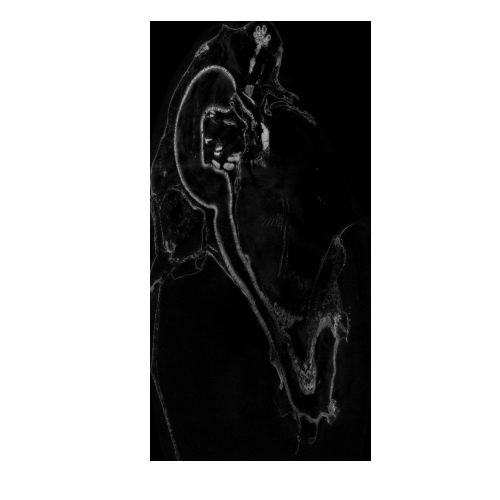

Button(description='save', style=ButtonStyle())

In [18]:
import SimpleITK as sitk
import numpy as np
from PIL import Image

def save_slice_as_jpg(input_file, slice_index, output_path=None):
    # Load the .mha file
    image = sitk.ReadImage(input_file)
    image_array = sitk.GetArrayFromImage(image)  # shape: [slices, height, width]

    print(f'Image shape: {image_array.shape}')

    # Check if the slice index is valid
    if slice_index < 0 or slice_index >= image_array.shape[0]:
        print(f'Error: Slice index {slice_index} is out of bounds.')
        return

    # Extract the slice
    selected_slice = image_array[slice_index]
    print(f'Slice {slice_index} shape: {selected_slice.shape}')

    # Normalize slice to 0-255
    slice_normalized = (selected_slice - np.min(selected_slice)) / (np.max(selected_slice) - np.min(selected_slice))
    slice_uint8 = (slice_normalized * 255).astype(np.uint8)

    # Define output path if not provided
    if output_path is None:
        output_path = f'slice.jpg'

    # Save as JPG
    img = Image.fromarray(slice_uint8)
    img.save(output_path)

    print(f'Slice {slice_index} saved as {output_path}')

# Example usage:
input_file = '/scratch/mtc5693/data/rachelles_results/female_daphnia_dataset_+_segmentation_files/aaa392_bin0_down.mha'
save_slice_as_jpg(input_file, slice_index=60)
 
img = "slice.jpg"
bbox_prompt_demo = BboxPromptDemo(medsam_model)
bbox_prompt_demo.show(img)

In [25]:
#!/usr/bin/env python
"""
Batch Segmentation Script for 3D Medical Images using MedSAM 
(Interactive Preprocessing Replication)

This script loads a 3D MHA image, then for each slice it:
  1. Resizes the entire slice to 1024×1024 (ignoring aspect ratio)
  2. Normalizes the resized image to [0,1]
  3. Scales the bounding box from original coordinates to 1024×1024 coordinates
  4. Runs inference with a tight (or full) bounding box using multimask_output=False
  5. Upsamples the final mask back to the original slice size

This version also visualizes every 20th slice with three panels:
  - Original image
  - Ground Truth overlay (if available)
  - Prediction overlay

Requirements:
  - Python 3.10+
  - PyTorch
  - SimpleITK
  - OpenCV (cv2)
  - numpy, matplotlib, tqdm, pandas
  - MedSAM from https://github.com/bowang-lab/MedSAM

Usage:
  python batch_segment_interactive.py
"""

import os
import numpy as np
import torch
import cv2
import SimpleITK as sitk
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Import MedSAM components
from segment_anything import sam_model_registry

def preprocess_image_interactive(slice_img):
    """
    Preprocess the input slice exactly like the interactive demo:
      - If grayscale, convert to 3-channel.
      - Resize (warp) to 1024x1024.
      - Normalize to [0,1].
    
    Args:
        slice_img: Input slice (H, W) or (H, W, 3)
    
    Returns:
        resized_img: Preprocessed image as a float32 NumPy array of shape (1024,1024,3)
    """
    # If the image is grayscale, convert it to 3 channels.
    if len(slice_img.shape) == 2:
        slice_img = cv2.cvtColor(slice_img, cv2.COLOR_GRAY2BGR)
    
    # Resize (warp) the image to 1024×1024
    resized_img = cv2.resize(slice_img, (1024, 1024), interpolation=cv2.INTER_CUBIC)
    
    # Normalize to [0, 1] using min-max normalization
    resized_img = resized_img.astype(np.float32)
    resized_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min() + 1e-8)
    
    return resized_img

def scale_bbox(bbox, orig_shape):
    """
    Scale bounding box coordinates from original image size to 1024x1024 coordinates.
    
    Args:
        bbox: list or array of [x0, y0, x1, y1] in original coordinates.
        orig_shape: tuple (orig_H, orig_W)
    
    Returns:
        bbox_scaled: numpy array of shape (4,) with coordinates scaled to 1024x1024.
    """
    orig_H, orig_W = orig_shape
    scale = np.array([1024/orig_W, 1024/orig_H, 1024/orig_W, 1024/orig_H])
    bbox_scaled = np.array(bbox) * scale
    return bbox_scaled

def predict_with_box_interactive(model, slice_img, bbox, device="cuda:0"):
    """
    Predict segmentation mask for a slice using interactive preprocessing.
    
    Args:
        model: Trained MedSAM model.
        slice_img: Original slice as a NumPy array (grayscale or color).
        bbox: Bounding box in original image coordinates [x0, y0, x1, y1].
              (For a full image, use [0, 0, orig_W, orig_H])
        device: Device string, e.g., "cuda:0" or "cpu".
    
    Returns:
        final_mask: Binary segmentation mask (numpy uint8) with original slice dimensions.
    """
    orig_H, orig_W = slice_img.shape[:2]
    
    # Preprocess the image as in the interactive demo:
    img_1024 = preprocess_image_interactive(slice_img)
    
    # Convert preprocessed image to tensor: shape (1, 3, 1024, 1024)
    image_tensor = torch.from_numpy(img_1024).permute(2, 0, 1).unsqueeze(0).to(device).float()
    
    # Compute image embedding
    with torch.no_grad():
        image_embedding = model.image_encoder(image_tensor)
    
    # Scale the bounding box from original to 1024×1024 coordinates.
    bbox_1024 = scale_bbox(bbox, (orig_H, orig_W))
    bbox_1024 = torch.as_tensor(bbox_1024, dtype=torch.float32, device=device).unsqueeze(0)  # shape (1,4)
    # In the interactive demo, the bbox is used with an extra dimension:
    bbox_1024 = bbox_1024.unsqueeze(1)  # shape becomes (1,1,4)
    
    # Prompt encoding and mask decoding, with multimask_output set to False
    with torch.no_grad():
        sparse_embeddings, dense_embeddings = model.prompt_encoder(
            points=None,
            boxes=bbox_1024,
            masks=None,
        )
        low_res_logits, _ = model.mask_decoder(
            image_embeddings=image_embedding,
            image_pe=model.prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=False,
        )
        low_res_pred = torch.sigmoid(low_res_logits)  # shape (1,1,1024,1024)
        # Upsample to original image size
        upsampled = torch.nn.functional.interpolate(
            low_res_pred,
            size=(orig_H, orig_W),
            mode="bilinear",
            align_corners=False,
        )
        mask = upsampled.squeeze().cpu().numpy()  # shape (orig_H, orig_W)
    
    final_mask = (mask > 0.5).astype(np.uint8)
    return final_mask

def compute_dice_score(pred, gt):
    """
    Compute the Dice coefficient between prediction and ground truth.
    """
    intersection = np.sum((pred > 0) & (gt > 0))
    return (2.0 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

def main():
    # ==== Configuration ====
    device = "cuda:0"  # or "cpu" if CUDA is unavailable
    
    # Path to the converted MedSAM checkpoint (modify accordingly)
    medsam_ckpt_path = "/scratch/mtc5693/MedSAM/work_dir/MedSAM-ViT-B-20250405-2141/medsam_converted.pth"
    
    # 3D volume
    input_image_path = "/scratch/mtc5693/data/rachelles_results/female_daphnia_dataset_+_segmentation_files/aaa392_bin0_down.mha"
    # (Optional) GT for dice
    gt_path = "/scratch/mtc5693/data/rachelles_results/female_daphnia_dataset_+_segmentation_files/aaa392_bin0_gomask_down.nii.gz"

    # Where to save results
    out_pred_path = "predicted_segmentation.mha"
    vis_dir = "visuals_batch_demo"
    os.makedirs(vis_dir, exist_ok=True)
    
    # ==== 1. Load the MedSAM model ====
    print("Loading MedSAM model...")
    sam_model = sam_model_registry["vit_b"](checkpoint=medsam_ckpt_path)
    sam_model = sam_model.to(device)
    sam_model.eval()
    
    # ==== 2. Load the 3D Volume ====
    print("Loading input image...")
    image_itk = sitk.ReadImage(input_image_path)
    image_np = sitk.GetArrayFromImage(image_itk)  # shape: (slices, H, W)
    print(f"Input image shape: {image_np.shape}")
    
    # ==== 3. (Optional) Load Ground Truth ====
    use_gt = False
    if gt_path is not None and os.path.isfile(gt_path):
        gt_itk = sitk.ReadImage(gt_path)
        gt_np = sitk.GetArrayFromImage(gt_itk)
        if gt_np.shape == image_np.shape:
            use_gt = True
            print("Ground truth loaded for Dice computation.")
        else:
            print("Ground truth shape does not match input image shape. Skipping GT.")
    else:
        print("No ground truth provided. Skipping Dice computation.")
    
    dices = []
    predictions = []
    
    # ==== 4. Process Each Slice ====
    print("Starting batch segmentation...")
    for i in tqdm(range(image_np.shape[0]), desc="Segmenting slices"):
        slice_img = image_np[i]
        orig_H, orig_W = slice_img.shape[:2]
        
        # For a full-box prompt, use the entire image:
        full_bbox = [0, 0, orig_W, orig_H]
        
        pred_mask = predict_with_box_interactive(model=sam_model, slice_img=slice_img, bbox=full_bbox, device=device)
        predictions.append(pred_mask)
        
        # Compute Dice score if ground truth is available
        if use_gt:
            gt_mask = (gt_np[i] > 0).astype(np.uint8)
            dice_val = compute_dice_score(pred_mask, gt_mask)
            dices.append(dice_val)
        
        # Updated visualization every 20 slices: Show Original, GT overlay, and Prediction overlay side by side.
        if i % 20 == 0:
            # Preprocess slice for display (warp to 1024x1024, normalized)
            img_disp = preprocess_image_interactive(slice_img)
            img_disp_uint8 = (img_disp * 255).astype(np.uint8)
            
            # Prepare Ground Truth overlay if available.
            if use_gt:
                gt_mask = (gt_np[i] > 0).astype(np.uint8)
                # Resize GT mask to 1024x1024 for display
                gt_mask_disp = cv2.resize(gt_mask.astype(np.uint8)*255, (1024, 1024), interpolation=cv2.INTER_NEAREST)
                # Create a red mask overlay
                red_mask = np.zeros_like(img_disp_uint8)
                red_mask[:] = [255, 0, 0]
                gt_overlay = cv2.addWeighted(img_disp_uint8, 0.7, cv2.bitwise_and(red_mask, red_mask, mask=gt_mask_disp), 0.3, 0)
            else:
                gt_overlay = np.full_like(img_disp_uint8, 200)
                cv2.putText(gt_overlay, "No GT", (50, 512), cv2.FONT_HERSHEY_SIMPLEX, 2, (0,0,0), 3)
            
            # Prepare Prediction overlay.
            pred_mask_disp = cv2.resize(pred_mask.astype(np.uint8)*255, (1024, 1024), interpolation=cv2.INTER_NEAREST)
            # Create a green mask overlay
            green_mask = np.zeros_like(img_disp_uint8)
            green_mask[:] = [0, 255, 0]
            pred_overlay = cv2.addWeighted(img_disp_uint8, 0.7, cv2.bitwise_and(green_mask, green_mask, mask=pred_mask_disp), 0.3, 0)
            
            # Create a figure with three side-by-side panels.
            fig, axes = plt.subplots(1, 3, figsize=(18, 6))
            axes[0].imshow(img_disp_uint8)
            axes[0].set_title("Original")
            axes[0].axis("off")
            
            axes[1].imshow(gt_overlay)
            axes[1].set_title("Ground Truth")
            axes[1].axis("off")
            
            axes[2].imshow(pred_overlay)
            axes[2].set_title("Prediction")
            axes[2].axis("off")
            
            plt.tight_layout()
            vis_path = os.path.join(vis_dir, f"slice_{i:03d}.png")
            plt.savefig(vis_path, dpi=100)
            plt.close()
    
    # ==== 5. Save the 3D Predicted Segmentation ====
    pred_vol = np.stack(predictions, axis=0).astype(np.uint8)
    pred_itk = sitk.GetImageFromArray(pred_vol)
    pred_itk.CopyInformation(image_itk)
    sitk.WriteImage(pred_itk, out_pred_path)
    print(f"Predicted segmentation saved to: {out_pred_path}")
    
    # ==== 6. (Optional) Compute and Save Dice Scores ====
    if use_gt and len(dices) > 0:
        mean_dice = np.mean(dices)
        print(f"Mean Dice Score: {mean_dice:.4f}")
        
        # Save per-slice Dice scores to CSV.
        df = pd.DataFrame({"slice": list(range(len(dices))), "dice": dices})
        df.to_csv("dice_scores.csv", index=False)
        print("Per-slice Dice scores saved to dice_scores.csv.")
        
        # Optionally, plot the Dice score curve.
        plt.figure(figsize=(10, 5))
        plt.plot(dices, marker='o')
        plt.title("Dice Score per Slice")
        plt.xlabel("Slice Index")
        plt.ylabel("Dice Score")
        plt.grid(True)
        plt.savefig("dice_curve.png", dpi=100)
        plt.close()
        print("Dice curve saved to dice_curve.png.")
    else:
        print("Dice computation skipped.")
    
if __name__ == "__main__":
    main()


Loading MedSAM model...
Loading input image...
Input image shape: (128, 1024, 512)
Ground truth loaded for Dice computation.
Starting batch segmentation...


Segmenting slices: 100%|██████████| 128/128 [00:15<00:00,  8.01it/s]


Predicted segmentation saved to: predicted_segmentation.mha
Mean Dice Score: 0.7918
Per-slice Dice scores saved to dice_scores.csv.
Dice curve saved to dice_curve.png.
